# ArXiv API

The ArXiV API allows programmatic access to the arXiv's e-print content and metadata. "The goal of the interface is to facilitate new and creative use of the the vast body of material on the arXiv by providing a low barrier to entry for application developers." https://arxiv.org/help/api

The API's user manual (https://arxiv.org/help/api/user-manual) provides helpful documentation for using the API and retrieving article metadata.

Our examples below will introduce you to the basics of querying the ArXiV API.

## Install Packages

In [1]:
import urllib
import arxiv
import requests
import json
import csv
import pandas as pd
from collections import Counter, defaultdict
import numpy as np # for array manipulation
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline 
import datetime

## Query the API

Perform a simple query for "graphene." We'll limit results to the titles of the 10 most recent papers. 

In [2]:
search = arxiv.Search(
  query = "graphene",
  max_results = 10,
  sort_by = arxiv.SortCriterion.SubmittedDate
)

for result in search.results():
  print(result.title)

A family of ideal Chern flat bands with arbitrary Chern number in chiral twisted graphene multilayers
Correlated insulators, density wave states, and their nonlinear optical response in magic-angle twisted bilayer graphene
Gate-versus defect-induced voltage drop and negative differential resistance in vertical graphene heterostructures
Enhancing the hybridization of plasmons in graphene with 2D superconductor collective modes
Anisotropy of the proton kinetic energy as a tool for capturing structural transition in nanoconfined H$_2$O
Metal-Insulator transition in strained Graphene: A quantum Monte carlo study
Non-perturbative field theoretical aspects of graphene and related systems
Hierarchy of Ideal Flatbands in Chiral Twisted Multilayer Graphene Models
Inducing a topological transition in graphene nanoribbons superlattices by external strain
Engineering the Electronic Structure of Two-Dimensional Materials with Near-Field Electrostatic Effects of Self-Assembled Organic Layers


Do another query for the topic "quantum dots," but note that you could swap in a topic of your liking.

You can define a custom arXiv API client with specialized pagination behavior. This time we'll process each paper as it's fetched rather than exhausting the result-generator into a `list`; this is useful for running analysis while the client sleeps.

Because this `arxiv.Search` doesn't bound the number of results with `max_results`, it will fetch *every* matching paper (roughly 10,000). This may take several minutes.

In [3]:
results_generator = arxiv.Client(
  page_size=1000,
  delay_seconds=3,
  num_retries=3
).results(arxiv.Search(
  query='"quantum dots"',
  id_list=[],
  sort_by=arxiv.SortCriterion.Relevance,
  sort_order=arxiv.SortOrder.Descending,
))

quantum_dots = []
for paper in results_generator:
  # You could do per-paper analysis here; for now, just collect them in a list.
  quantum_dots.append(paper)

## Organize and analyze your results

Create a dataframe to better analyze your results. This example uses Python's [`vars`](https://docs.python.org/3/library/functions.html#vars) built-in function to convert search results into Python dictionaries of paper metadata.

In [4]:
qd_df = pd.DataFrame([vars(paper) for paper in quantum_dots])

We'll look at the first 10 results.

In [5]:
qd_df.head(10)

,entry_id,updated,published,title,authors,summary,comment,journal_ref,doi,primary_category,categories,links,pdf_url,_raw
0,http://arxiv.org/abs/cond-mat/0310363v1,2003-10-15 20:15:59+00:00,2003-10-15 20:15:59+00:00,Excitonic properties of strained wurtzite and ...,"[Vladimir A. Fonoberov, Alexander A. Balandin]",We investigate exciton states theoretically in...,"18 pages, accepted for publication in the Jour...","J. Appl. Phys. 94, 7178 (2003)",10.1063/1.1623330,cond-mat.mes-hall,[cond-mat.mes-hall],"[http://dx.doi.org/10.1063/1.1623330, http://a...",http://arxiv.org/pdf/cond-mat/0310363v1,{'id': 'http://arxiv.org/abs/cond-mat/0310363v...
1,http://arxiv.org/abs/2008.11666v1,2020-08-26 16:48:21+00:00,2020-08-26 16:48:21+00:00,A two-dimensional array of single-hole quantum...,"[F. van Riggelen, N. W. Hendrickx, W. I. L. La...",Quantum dots fabricated using techniques and m...,"7 pages, 4 figures",None,10.1063/5.0037330,cond-mat.mes-hall,[cond-mat.mes-hall],"[http://dx.doi.org/10.1063/5.0037330, http://a...",http://arxiv.org/pdf/2008.11666v1,"{'id': 'http://arxiv.org/abs/2008.11666v1', 'g..."
2,http://arxiv.org/abs/cond-mat/0411742v1,2004-11-30 02:56:15+00:00,2004-11-30 02:56:15+00:00,Polar optical phonons in wurtzite spheroidal q...,"[Vladimir A. Fonoberov, Alexander A. Balandin]",Polar optical-phonon modes are derived analyti...,11 pages,"J. Phys.: Condens. Matter 17, 1085 (2005)",10.1088/0953-8984/17/7/003,cond-mat.mes-hall,[cond-mat.mes-hall],"[http://dx.doi.org/10.1088/0953-8984/17/7/003,...",http://arxiv.org/pdf/cond-mat/0411742v1,{'id': 'http://arxiv.org/abs/cond-mat/0411742v...
3,http://arxiv.org/abs/1403.4790v1,2014-03-19 13:03:49+00:00,2014-03-19 13:03:49+00:00,Group-velocity slowdown in quantum-dots and qu...,"[Stephan Michael, Weng W. Chow, Hans Christian...",We investigate theoretically the slowdown of o...,Physics and Simulation of Optoelectronic Devic...,None,10.1117/12.2042412,cond-mat.mes-hall,"[cond-mat.mes-hall, cond-mat.mtrl-sci]","[http://dx.doi.org/10.1117/12.2042412, http://...",http://arxiv.org/pdf/1403.4790v1,"{'id': 'http://arxiv.org/abs/1403.4790v1', 'gu..."
4,http://arxiv.org/abs/cond-mat/0403328v1,2004-03-12 18:28:06+00:00,2004-03-12 18:28:06+00:00,A new method to epitaxially grow long-range or...,"[J. Bauer, D. Schuh, E. Uccelli, R. Schulz, A....",We report on a new approach for positioning of...,None,None,None,cond-mat.mes-hall,[cond-mat.mes-hall],"[http://arxiv.org/abs/cond-mat/0403328v1, http...",http://arxiv.org/pdf/cond-mat/0403328v1,{'id': 'http://arxiv.org/abs/cond-mat/0403328v...
5,http://arxiv.org/abs/cond-mat/0411484v1,2004-11-18 16:47:14+00:00,2004-11-18 16:47:14+00:00,Giant optical anisotropy in a single InAs quan...,"[I. Favero, Guillaume Cassabois, A. Jankovic, ...",We present the experimental evidence of giant ...,submitted to Applied Physics Letters,None,10.1063/1.1854733,cond-mat.other,[cond-mat.other],"[http://dx.doi.org/10.1063/1.1854733, http://a...",http://arxiv.org/pdf/cond-mat/0411484v1,{'id': 'http://arxiv.org/abs/cond-mat/0411484v...
6,http://arxiv.org/abs/1003.2350v1,2010-03-11 15:52:09+00:00,2010-03-11 15:52:09+00:00,Linewidth broadening of a quantum dot coupled ...,"[Arka Majumdar, Andrei Faraon, Erik Kim, Dirk ...",We study the coupling between a photonic cryst...,"5 pages, 4 figures",None,10.1103/PhysRevB.82.045306,quant-ph,[quant-ph],"[http://dx.doi.org/10.1103/PhysRevB.82.045306,...",http://arxiv.org/pdf/1003.2350v1,"{'id': 'http://arxiv.org/abs/1003.2350v1', 'gu..."
7,http://arxiv.org/abs/1201.1258v1,2012-01-05 18:56:21+00:00,2012-01-05 18:56:21+00:00,Photoluminescence from In0.5Ga0.5As/GaP quantu...,"[Kelley Rivoire, Sonia Buckley, Yuncheng Song,...",We demonstrate room temperature visible wavele...,None,None,10.1103/PhysRevB.85.045319,quant-ph,"[quant-ph, physics.optics]","[http://dx.doi.org/10.1103/PhysRevB.85.045319,...",http://arxiv.org/pdf/1201.1258v1,"{'id': 'http://arxiv.org/abs/1201.1258v1', 'gu..."
8,http://arxiv.org/abs/1206.2674v1,2012-06-12 21:00:22+00:00

Next, we'll create list of all of the columns in the dataframe to see what else is there:

In [6]:
list(qd_df)

['entry_id',
 'updated',
 'published',
 'title',
 'authors',
 'summary',
 'comment',
 'journal_ref',
 'doi',
 'primary_category',
 'categories',
 'links',
 'pdf_url',
 '_raw']

We have 14 columns overall. We'll add two derived columns––the name of the first listed author and a reference to the original `arxiv.Result` object-–then narrow the dataframe to paper titles, `published` dates, and first authors to run some analysis of publishing patterns over time.

In [7]:
# Add a first_author column: the name of the first author among each paper's list of authors.
qd_df['first_author'] = [authors_list[0].name for authors_list in qd_df['authors']]
# Keep a reference to the original results in the dataframe: this is useful for downloading PDFs.
qd_df['_result'] = quantum_dots

# Narrow our dataframe to just the columns we want for our analysis.
qd_df = qd_df[['title', 'published', 'first_author', '_result']]
qd_df

,title,published,first_author,_result
0,Excitonic properties of strained wurtzite and ...,2003-10-15 20:15:59+00:00,Vladimir A. Fonoberov,http://arxiv.org/abs/cond-mat/0310363v1
1,A two-dimensional array of single-hole quantum...,2020-08-26 16:48:21+00:00,F. van Riggelen,http://arxiv.org/abs/2008.11666v1
2,Polar optical phonons in wurtzite spheroidal q...,2004-11-30 02:56:15+00:00,Vladimir A. Fonoberov,http://arxiv.org/abs/cond-mat/0411742v1
3,Group-velocity slowdown in quantum-dots and qu...,2014-03-19 13:03:49+00:00,Stephan Michael,http://arxiv.org/abs/1403.4790v1
4,A new method to epitaxially grow long-range or...,2004-03-12 18:28:06+00:00,J. Bauer,http://arxiv.org/abs/cond-mat/0403328v1
...,...,...,...,...
10761,Integrated photonics enables continuous-beam e...,2021-05-08 16:17:01+00:00,J. -W. Henke,http://arxiv.org/abs/2105.03729v2
10762,Asymptotic entanglement sudden death in two at...,2021-05-12 14:29:44+00:00,Gehad Sadiek,http://arxiv.org/abs/2105.05694v1
10763,Engineering interfacial quantum states and ele...,2021-07-21 15:19:10+00:00,Ignacio Piquero-Zulaica,http://arxiv.org/abs/2107.10141v1
10764,Implementation of the SMART protocol for globa...,2021-08-02 12:46:49+00:00,Ingvild Hansen,http://arxiv.org/abs/2108.00836v3


## Visualize your results

Get a sense of the how your topic has trended over time. When did research on your topic take off? Create a bar chart of the number of articles published in each year.

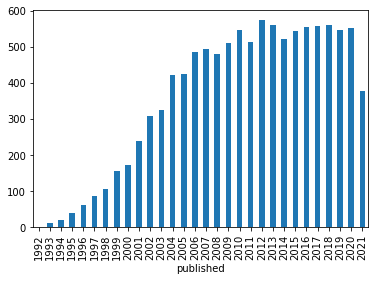

In [8]:
qd_df["published"].groupby(qd_df["published"].dt.year).count().plot(kind="bar")

Explore authors to see who is publishing your topic. Group by author, then sort and select the top 20 authors.

In [9]:
qd_authors = qd_df.groupby(qd_df["first_author"])["first_author"].count().sort_values(ascending=False)
qd_authors.head(20)

first_author
Bing Dong                 27
Y. Alhassid               20
Constantine Yannouleas    18
David M. -T. Kuo          16
Akira Oguri               15
Xuedong Hu                15
Kicheon Kang              14
B. Szafran                14
Rafael Sánchez            14
Massimo Rontani           14
Ulrich Hohenester         14
C. W. J. Beenakker        13
P. W. Brouwer             13
O. Entin-Wohlman          12
G. Giavaras               12
Vidar Gudmundsson         12
Piotr Trocha              12
Arka Majumdar             11
A. A. Aligia              11
Ramin M. Abolfath         11
Name: first_author, dtype: int64

## Identify and download papers

Let's download the oldest paper about quantum dots co-authored by Piotr Trocha:

In [10]:
qd_Trocha_sorted  = qd_df[qd_df['first_author']=='Piotr Trocha'].sort_values('published')
qd_Trocha_sorted

,title,published,first_author,_result
848,Dicke-like effect in spin-polarized transport ...,2007-11-22 16:11:11+00:00,Piotr Trocha,http://arxiv.org/abs/0711.3611v2
2270,Kondo-Dicke resonances in electronic transport...,2008-03-28 15:49:07+00:00,Piotr Trocha,http://arxiv.org/abs/0803.4154v1
3315,Negative tunnel magnetoresistance and differen...,2009-11-02 11:45:03+00:00,Piotr Trocha,http://arxiv.org/abs/0911.0291v1
5772,Beating in electronic transport through quantu...,2010-04-11 16:20:04+00:00,Piotr Trocha,http://arxiv.org/abs/1004.1819v2
2391,Orbital Kondo effect in double quantum dots,2010-08-17 14:13:23+00:00,Piotr Trocha,http://arxiv.org/abs/1008.2902v2
2428,The influence of spin-flip scattering on the p...,2011-05-08 20:12:41+00:00,Piotr Trocha,http://arxiv.org/abs/1105.1550v1
5402,Large enhancement of thermoelectric effects in...,2011-08-11 14:49:51+00:00,Piotr Trocha,http://arxiv.org/abs/1108.2422v2
7661,The role of the indirect tunneling processes a...,2011-09-12 20:51:49+00:00,Piotr Trocha,http://arxiv.org/abs/1109.2621v1
2613,Spin-polarized Andreev transport influenced by...,2014-09-14 23:54:35+00:00,Piotr Trocha,http://arxiv.org/abs/1409.4122v1
7789,Spin-resolved Andreev transport through double...,2015-08-24 19:02:49+00:00,Piotr Trocha,http://arxiv.org/abs/1508.05915v1


In [ ]:
# Use the arxiv.Result object stored in the _result column to trigger a PDF download.
qd_Trocha_oldest = qd_Trocha_sorted.iloc[0]
qd_Trocha_oldest._result.download_pdf()

Confirm that the PDF has downloaded!

## Bibliography

- Tim Head: https://betatim.github.io/posts/analysing-the-arxiv/
- Lukas Schwab: https://github.com/lukasschwab/arxiv.py
- ArXiV API user manual: https://arxiv.org/help/api/user-manual        